# Feedforward Network

In [1]:
import torch
import numpy as np
import sys

In [2]:
torch.__version__

'2.2.2'

In [3]:
torch.manual_seed(42)

In [4]:
#We can check whether we have gpu
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device: ", device)

Device:  cpu


Let's have linear regression as a case study to study the different components of PyTorch.  These are the following components we will be covering:

1. Specifying input and target
2. Dataset and DataLoader
3. `nn.Linear` (Dense)
4. Define loss function
5. Define optimizer function
6. Train the model

Consider this data:

<img src = "figures/japan.png" width="400">

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

$$\text{yield}_\text{apple}  = w_{11} * \text{temp} + w_{12} * \text{rainfall} + w_{13} * \text{humidity} + b_{1}$$

$$\text{yield}_\text{orange} = w_{21} * \text{temp} + w_{22} * \text{rainfall} + w_{23} * \text{humidity} + b_{2}$$

Visually, it means that the yield of apples is a linear or planar function of temperature, rainfall and humidity:

<img src = "figures/japan2.png" width="400">

The learning part of linear regression is to figure out a set of weights <code>w11, w12,... w23, b1 \& b2</code> using gradient descent

## 1. Specifiying input and target

In [5]:
# Input (temp, rainfall, humidity)
x_train = np.array([[73, 67, 43], [91, 88, 64], [87, 134, 58], 
                   [102, 43, 37], [69, 96, 70], [73, 67, 43], 
                   [91, 88, 64], [87, 134, 58], [102, 43, 37], 
                   [69, 96, 70], [73, 67, 43], [91, 88, 64], 
                   [87, 134, 58], [102, 43, 37], [69, 96, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
y_train = np.array([[56, 70], [81, 101], [119, 133], 
                    [22, 37], [103, 119], [56, 70], 
                    [81, 101], [119, 133], [22, 37], 
                    [103, 119], [56, 70], [81, 101], 
                    [119, 133], [22, 37], [103, 119]], 
                   dtype='float32')

inputs = torch.from_numpy(x_train)
targets = torch.from_numpy(y_train)
print(inputs.size())
print(targets.size())

torch.Size([15, 3])
torch.Size([15, 2])


## 2. Dataset and DataLoader

We'll create a <code>TensorDataset</code>, which allows access to rows from inputs and targets as tuples, and if we want to use <code>DataLoader</code> (will talk shortly) from numpy array, we have to first make <code>TensorDataset</code>.

In [6]:
from torch.utils.data import TensorDataset

In [7]:
# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

We'll now create a <code>DataLoader</code>, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

In [8]:
from torch.utils.data import DataLoader

In [9]:
# Define data loader
batch_size = 3
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

The data loader is typically used in a for-in loop. Let's look at an example

In [10]:
for xb, yb in train_dl:
    print(xb)
    print(yb)
    break

tensor([[102.,  43.,  37.],
        [ 87., 134.,  58.],
        [ 73.,  67.,  43.]])
tensor([[ 22.,  37.],
        [119., 133.],
        [ 56.,  70.]])


In each iteration, the data loader returns one batch of data, with the given batch size. If shuffle is set to True, it shuffles the training data before creating batches. Shuffling helps randomize the input to the optimization algorithm, which can lead to faster reduction in the loss.

## 3. Define some layer - nn.Linear

Instead of initializing the weights & biases manually, we can define the model using the <code>nn.Linear</code> class from PyTorch, which does it automatically.

In [11]:
import torch.nn as nn

# Define model
model = nn.Linear(3, 2)  #nn.Linear assume this shape (in_features, out_features)
print(model.weight)
print(model.weight.size()) # (out_features, in_features)
print(model.bias)
print(model.bias.size()) #(out_features)

Parameter containing:
tensor([[-0.1265,  0.1165, -0.2811],
        [ 0.3391,  0.5090, -0.4236]], requires_grad=True)
torch.Size([2, 3])
Parameter containing:
tensor([0.5018, 0.1081], requires_grad=True)
torch.Size([2])


In fact, our model is simply a function that performs a matrix multiplication of the <code>inputs</code> and the weights <code>w</code> and adds the bias <code>b</code> (for each observation)

<img src = "figures/dot.png" width="400">

PyTorch models also have a helpful <code>.parameters</code> method, which returns a list containing all the weights and bias matrices present in the model. For our linear regression model, we have one weight matrix and one bias matrix.

In [12]:
# Parameters
list(model.parameters())  #model.param returns a generator

[Parameter containing:
 tensor([[-0.1265,  0.1165, -0.2811],
         [ 0.3391,  0.5090, -0.4236]], requires_grad=True),
 Parameter containing:
 tensor([0.5018, 0.1081], requires_grad=True)]

In [13]:
#we can print the complexity by the number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

8


We can use the <code>model(tensor)</code> API to perform a forward-pass that generate predictions

In [14]:
# Generate predictions
preds = model(inputs)
preds

tensor([[-13.0136,  40.7472],
        [-18.7468,  48.6438],
        [-11.1951,  73.2410],
        [-17.7916,  40.9065],
        [-16.7183,  42.7146],
        [-13.0136,  40.7472],
        [-18.7468,  48.6438],
        [-11.1951,  73.2410],
        [-17.7916,  40.9065],
        [-16.7183,  42.7146],
        [-13.0136,  40.7472],
        [-18.7468,  48.6438],
        [-11.1951,  73.2410],
        [-17.7916,  40.9065],
        [-16.7183,  42.7146]], grad_fn=<AddmmBackward0>)

## 4. Define loss function

The <code>nn</code> module contains a lot of useful loss function like this:

In [15]:
criterion_mse = nn.MSELoss() #linear 
criterion_softmax_cross_entropy_loss = nn.CrossEntropyLoss() #classification

In [16]:
mse = criterion_mse(preds, targets)
print(mse)
print(mse.item())  ##print out the loss number

tensor(6058.1660, grad_fn=<MseLossBackward0>)
6058.166015625


## 5. Define the optimizer

We use <code>optim.SGD</code> to perform stochastic gradient descent where samples are selected in batches (often with random shuffling) instead of as a single group.  Note that <code>model.parameters()</code> is passed as an argument to <code>optim.SGD</code>.

In [17]:
# Define optimizer
#momentum update the weight based on past gradients also, which will be useful for getting out of local max/min
#If our momentum parameter was $0.9$, we would get our current grad + the multiplication of the gradient 
#from one time step ago by $0.9$, the one from two time steps ago by $0.9^2 = 0.81$, etc.
opt = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9) 

/Users/guntsv/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 6. Training - putting everything together

In [29]:
import matplotlib.pyplot as plt

# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl):
    losses = []  # List to store losses
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Initialize epoch loss
        
        # Train with batches of data
        for xb, yb in train_dl:
            xb.to(device)
            yb.to(device)
                    
            # 1. Predict
            pred = model(xb)
                      
            # 2. Calculate loss
            loss = loss_fn(pred, yb)
            epoch_loss += loss.item() * xb.size(0)  # Accumulate epoch loss
            
            # 3. Calculate gradient
            opt.zero_grad()
            loss.backward()
            
            # 4. Update parameters using gradients
            opt.step()
        
        epoch_loss /= len(train_dl.dataset)  # Calculate average epoch loss
        losses.append(epoch_loss)  # Append epoch loss to the list
        
        # Print the progress
        if (epoch+1) % 10 == 0:
            # sys.stdout.write("\rEpoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, epoch_loss))
            print("\rEpoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, epoch_loss))
    
    # Plot the losses
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

Epoch [10/100], Loss: 2.3727
Epoch [20/100], Loss: 231.8595
Epoch [30/100], Loss: 64.6075
Epoch [40/100], Loss: 3.4105
Epoch [50/100], Loss: 29.2946
Epoch [60/100], Loss: 123.3069
Epoch [70/100], Loss: 18.1094
Epoch [80/100], Loss: 71.8158
Epoch [90/100], Loss: 20.0354
Epoch [100/100], Loss: 9.9275


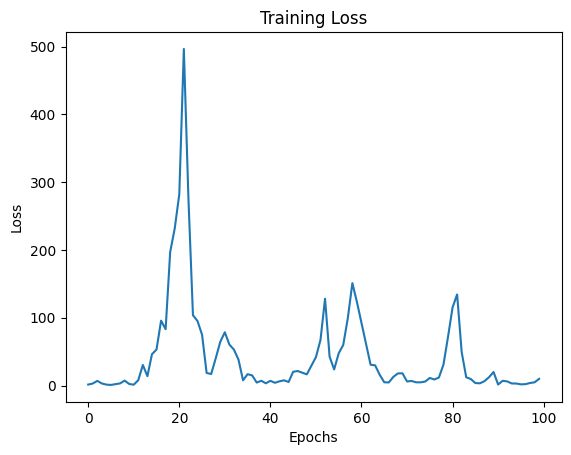

In [30]:
#train for 100 epochs
fit(100, model, criterion_mse, opt, train_dl)

In [20]:
# Generate predictions
preds = model(inputs)
loss = criterion_mse(preds, targets)
print(loss.item())

13.768152236938477
